In [1]:
import json
import csv
import pandas as pd
from sklearn import preprocessing
import numpy as np
import os
from collections.abc import Sequence
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show
import sklearn.feature_extraction.text as sk_text
from sklearn import metrics
import tensorflow.keras 
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint
from collections import Counter
from datetime import datetime
import h5py


In [2]:
### HELPER FUNCTIONS ###

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()


def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

In [3]:
#  tsv output file for cleaned up business json dataset
outfile = open("businesses.tsv", 'w')
businessfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL) 
businessfile.writerow(['business_id','name', 'stars', 'category'])

# Opens json dataset from path. 
with open('yelp_dataset/yelp_academic_dataset_business.json', encoding="utf-8") as f: 
    for line in f:
        row = json.loads(line)
        # Only getting businesses with review count over 20
        if row['review_count'] > 20:
            # some special char must be encoded in 'utf-8' 
            businessfile.writerow([row['business_id'], row['name'], row['stars'], row['categories']])

# Close tsv file
outfile.close()

# Create pandas dataframe tsv output file
df_business = pd.read_csv('businesses.tsv', delimiter ="\t", encoding="utf-8")
df_stars = df_business[['business_id', 'stars' , 'name']]

print(df_stars)

                  business_id  stars                           name
0      f9NumwFMBDn751xgFiRbNA    3.5       The Range At Lake Norman
1      51M2Kk903DFYI6gnB5I6SQ    4.5        USE MY GUY SERVICES LLC
2      cKyLV5oWZJ2NudWgqs8VZw    4.5    Oasis Auto Center - Gilbert
3      oiAlXZPIFm2nBCt0DHLu_Q    3.5           Green World Cleaners
4      uZuh51lXu7tsrC8RAwkg1A    4.5                 Manolo Blahnik
...                       ...    ...                            ...
63848  YZeUH6zYS0dq5QHLYZhUnQ    2.0                        Hooters
63849  xVpE01l6ZXdEtVf5PkRpDg    4.0                          Julep
63850  fNil19SUfPAPnLQrYnFrGQ    4.5  Cheyenne West Animal Hospital
63851  JjcJVqhZXhP4tvOhg3fnag    5.0              Water Heater Pros
63852  SYa2j1boLF8DcGVOYfHPcA    3.5                      Five Guys

[63853 rows x 3 columns]


In [4]:
# dict for business_ids of businesses used for project
# Will use this to search for the businesses chosen for project in the reviews json dataset
# and add it to reviews tsv
#chosen_business = { 'YZeUH6zYS0dq5QHLYZhUnQ':'Hooters', 'oiAlXZPIFm2nBCt0DHLu_Q': 'Green World Cleaners', 'fNil19SUfPAPnLQrYnFrGQ' :'Cheyenne West Animal Hospital',   'JjcJVqhZXhP4tvOhg3fnag' :'Water Heater Pros' }

# 5, 4, 3, 2, 1
chosen_business = {'3C0bnFhjkgYP9mWORKg6cA':'Chili Man', 'ZkzutF0P_u0C0yTulwaHkA':'Lelulos Pizzeria', '-LfTBo0oa_uD454ScEW2XA':'Merry Anns Diner','W7hCuNdn2gzehta6eSHzgQ':'Petes Fish & Chips', 'T0NKethAB-FFR05EeZCzuA':'Burger King', 'F7mv0e3N2DgYY93cl8LpZw':'Wendys'}

#  tsv output file for cleaned up review json dataset
outfile = open("review_stars.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL) 
sfile.writerow(['business_id','stars', 'text'])

# Opens json dataset from path. 
with open('yelp_dataset/yelp_academic_dataset_review.json', encoding="utf-8") as f: 
    for line in f:
        row = json.loads(line)
        # If statement to look for our chosen businesses
        if row['business_id'] in chosen_business: 
            # some special char must be encoded in 'utf-8' 
            sfile.writerow( [row['business_id'], row['stars'], (row['text']).encode('utf-8')])
        
            

# Close tsv file
outfile.close()

# Create pandas dataframe tsv output file
df = pd.read_csv('review_stars.tsv', delimiter ="\t", encoding="utf-8")



In [5]:


# Aggregate all reviews for each business into one column
df_review_agg = df.groupby('business_id')['text'].sum()
# Merge review dataframe with star rating from business dataframe using business_id
df_merge = pd.merge(df_review_agg, df_stars, on='business_id')

print(df_merge)

# Tfidf vectorizer for text column
vectorizer = sk_text.TfidfVectorizer(
                             stop_words='english',
                             max_features = 1000,
                             min_df=1)
text_vector = vectorizer.fit_transform(df_merge['text'])

# Merge vectorized text vector with dataframe
df_text = pd.DataFrame(text_vector.toarray())
df_concatenation = pd.concat([df_merge, df_text], axis=1)

business_names = []

business_names = df_concatenation['name']
# drop unnecessary columns for neural network
df_for_nn = df_concatenation.drop(['business_id','text','name'], axis=1) # drop unnecessary columns for neural network

print(df_for_nn)

              business_id                                               text  \
0  -LfTBo0oa_uD454ScEW2XA  b'I can\'t help but feel that the foodies who ...   
1  3C0bnFhjkgYP9mWORKg6cA  b'the BEST BEST hotdogs!! If you havent tried ...   
2  F7mv0e3N2DgYY93cl8LpZw  b"Bad service! Slow , food isn't always fresh....   
3  T0NKethAB-FFR05EeZCzuA  b"I don't know why I bother. After a log day a...   
4  W7hCuNdn2gzehta6eSHzgQ  b"Didn't care for our square fish or the sauce...   
5  ZkzutF0P_u0C0yTulwaHkA  b'Stopped here with my wife due to the 18" piz...   

   stars                 name  
0    3.0    Merry Ann's Diner  
1    5.0            Chili Man  
2    1.5              Wendy's  
3    1.5          Burger King  
4    2.0  Pete's Fish & Chips  
5    4.0     Lelulos Pizzeria  
   stars         0         1         2         3         4         5  \
0    3.0  0.006562  0.000000  0.000000  0.000000  0.017057  0.000000   
1    5.0  0.007453  0.005753  0.010068  0.001678  0.003229  0.003357   

In [6]:
x,y = to_xy(df_for_nn,"stars")
x_train, x_test, y_train, y_test = train_test_split (x, y, test_size=0.5, random_state=45)

In [2]:

hf = h5py.File('best_weights.hdf5', 'w')


hf.close()

NameError: name 'h5py' is not defined

In [3]:
model = Sequential()

model.add(Dense(500, input_dim=x.shape[1], activation='tanh'))
model.add(Dense(250, activation='sigmoid'))
model.add(Dense(125, activation='relu'))
model.add(Dense(1))

# model.add(Dense(500, input_dim=x.shape[1], activation='relu'))
# model.add(Dense(500, input_dim=x.shape[1], activation='sigmoid'))
# model.add(Dense(250, activation='relu'))
# model.add(Dense(125, activation='relu'))



# model.compile(loss='mean_squared_error', optimizer='sgd')
model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=2, mode='auto')

checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model


model.fit(x_train,y_train, validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=1000)    # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.

model.load_weights('dnn/best_weights.hdf5')

NameError: name 'Sequential' is not defined

In [9]:
pred_test = model.predict(x_test)
print("Shape: {}".format(pred_test.shape))
print(pred_test)

pred_train = model.predict(x_train)

print(pred_train)

Shape: (3, 1)
[[2.6329334]
 [2.5836744]
 [2.6042163]]
[[2.653879 ]
 [2.6550343]
 [2.667114 ]]


In [10]:
# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred_test,y_test))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 1.5797936916351318


In [11]:
for i in range(pred_test.shape[0]):
    print("{}. Business Name: {}, Star Rating: {}, predicted Star Rating: {}".format(i+1,business_names[i],y[i],pred_test[i]))
    
for i in range(pred_train.shape[0]):
    print("{}. Business Name: {}, Star Rating: {}, predicted Star Rating: {}".format(i+4,business_names[i+3],y[i+3],pred_train[i]))

1. Business Name: Merry Ann's Diner, Star Rating: 3.0, predicted Star Rating: [2.6329334]
2. Business Name: Chili Man, Star Rating: 5.0, predicted Star Rating: [2.5836744]
3. Business Name: Wendy's, Star Rating: 1.5, predicted Star Rating: [2.6042163]
4. Business Name: Burger King, Star Rating: 1.5, predicted Star Rating: [2.653879]
5. Business Name: Pete's Fish & Chips, Star Rating: 2.0, predicted Star Rating: [2.6550343]
6. Business Name: Lelulos Pizzeria, Star Rating: 4.0, predicted Star Rating: [2.667114]


In [12]:
# print out prediction
df_y = pd.DataFrame(y_test, columns=['ground_truth'])
df_pred = pd.DataFrame(pred_test, columns=['predicted'])
result = pd.concat([df_y, df_pred],axis=1)
result

,ground_truth,predicted
0,1.5,2.632933
1,5.0,2.583674
2,2.0,2.604216


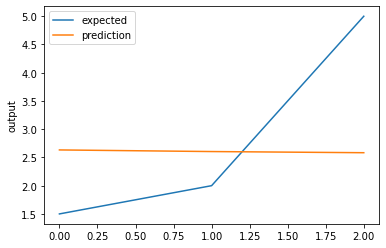

In [13]:
chart_regression(pred_test.flatten(),y_test, sort=True)